In [1]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from itertools import chain
import seaborn as sns
from datetime import datetime

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.image import resample_img
from nilearn.image import new_img_like, load_img, clean_img, crop_img
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from glob import glob

# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
from torchsummary import summary
from tensorboardX import SummaryWriter

from IPython import display
%matplotlib inline

In [2]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

class MyDataset(Dataset):
    def __init__(self, task_type, test_size=0.2, test=False, scaler='minmax',
                path='../../brainmask_reg/*.npy'):

        self.scaler = scaler

        RANDOM_STATE = 42
        np.random.seed(RANDOM_STATE)

        data_files = glob(path)
        data_files.sort()

        test_num = int(test_size * len(data_files))
        train_num = len(data_files) - test_num
        shuffled_index = np.random.permutation(len(data_files))

        train_fname = [data_files[i] for i in shuffled_index[:train_num]]
        test_fname = [data_files[i] for i in shuffled_index[-test_num:]]

        label_file = pd.read_csv('../rsc/age_ixi_and_oasis.csv', index_col=0)

        if test:
            self.data_files = [data_files[i] for i in shuffled_index[-test_num:]]
            self.label_file = label_file[task_type].values[shuffled_index[-test_num:]]

        else:
            self.data_files = [data_files[i] for i in shuffled_index[:train_num]]
            self.label_file = label_file[task_type].values[shuffled_index[:train_num]]

    def __getitem__(self, idx):
        
        if self.scaler == 'minmax':
            x = np.load(self.data_files[idx])[55:201, 44:186, 20:193]
            x = MinMaxScaler().fit_transform(x.reshape(-1, 1)).reshape(146, 142, 173)

        else:
            x = np.load(self.data_files[idx])
            
        x = torch.tensor(x)[None, :, :].float()
        y = torch.tensor(self.label_file[idx]).float()
        return x, y

    def __len__(self):
        return len(self.data_files)

In [3]:
train_dset = MyDataset(task_type='age')
test_dset = MyDataset(task_type='age', test=True)

train_loader = DataLoader(train_dset, batch_size=16)
test_loader = DataLoader(test_dset, batch_size=16)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Levakov(nn.Module):

    def __init__(self, task_type=None):
        super(Levakov, self).__init__()
        self.task_type = task_type

        self.BN = nn.BatchNorm3d(1)
        self.layer1 = nn.Sequential(
            nn.Conv3d(1, 8, 3), nn.ReLU(),
            nn.Conv3d(8, 8, 3), nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.BatchNorm3d(8)
        )

        self.layer2 = nn.Sequential(
            nn.Conv3d(8,  16, 3), nn.ReLU(),
            nn.Conv3d(16, 16, 3), nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.BatchNorm3d(16),
            nn.Dropout(.5)
        )

        self.layer3 = nn.Sequential(
            nn.Conv3d(16, 32, 3), nn.ReLU(),
            nn.Conv3d(32, 32, 3), nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.BatchNorm3d(32),
            nn.Dropout(.5)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv3d(32, 64, 3), nn.ReLU(),
            nn.Conv3d(64, 64, 3), nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.BatchNorm3d(64),
            nn.Dropout(.5)
        )

        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(.3)


    def forward(self, x):

        x = self.BN(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = x.reshape(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


In [5]:
device = torch.device("cuda:0")

In [6]:
model = Levakov().to(device)
print(summary(model, input_size=(1, 96, 96, 96)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm3d-1        [-1, 1, 96, 96, 96]               2
            Conv3d-2        [-1, 8, 94, 94, 94]             224
              ReLU-3        [-1, 8, 94, 94, 94]               0
            Conv3d-4        [-1, 8, 92, 92, 92]           1,736
              ReLU-5        [-1, 8, 92, 92, 92]               0
         MaxPool3d-6        [-1, 8, 46, 46, 46]               0
       BatchNorm3d-7        [-1, 8, 46, 46, 46]              16
            Conv3d-8       [-1, 16, 44, 44, 44]           3,472
              ReLU-9       [-1, 16, 44, 44, 44]               0
           Conv3d-10       [-1, 16, 42, 42, 42]           6,928
             ReLU-11       [-1, 16, 42, 42, 42]               0
        MaxPool3d-12       [-1, 16, 21, 21, 21]               0
      BatchNorm3d-13       [-1, 16, 21, 21, 21]              32
          Dropout-14       [-1, 16, 21,

In [7]:
task_type = 'age'
resize = True
scheduler = False

In [19]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [9]:
summary = SummaryWriter(f'./tensorboard/{datetime.now().strftime("%Y-%m-%d_%H%M")}')

EPOCHS 300
TRAIN :: [LOSS] 6.333 | VALID :: [LOSS] 8.756


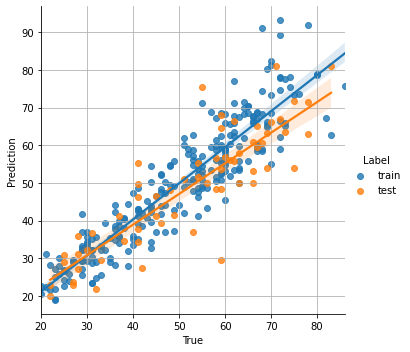

EPOCHS 301
TRAIN :: [LOSS] 6.046 | VALID :: [LOSS] 9.170


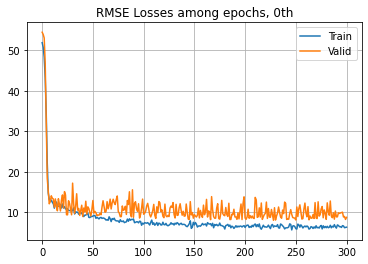

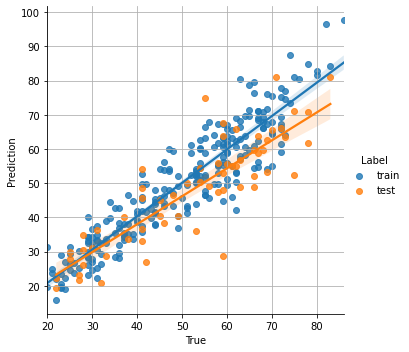

EPOCHS 302
TRAIN :: [LOSS] 6.428 | VALID :: [LOSS] 9.238


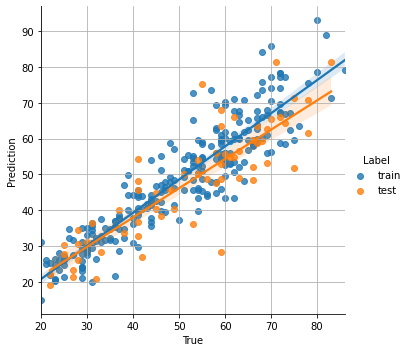

EPOCHS 303
TRAIN :: [LOSS] 6.080 | VALID :: [LOSS] 9.091


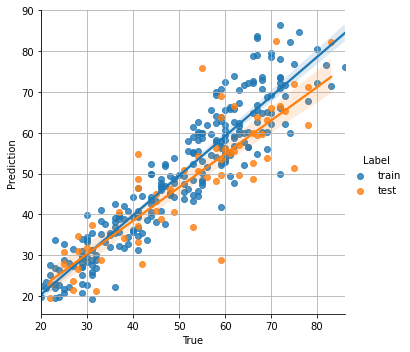

EPOCHS 304
TRAIN :: [LOSS] 5.975 | VALID :: [LOSS] 8.728


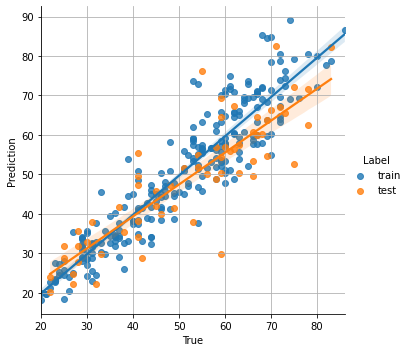

EPOCHS 305
TRAIN :: [LOSS] 6.131 | VALID :: [LOSS] 8.841


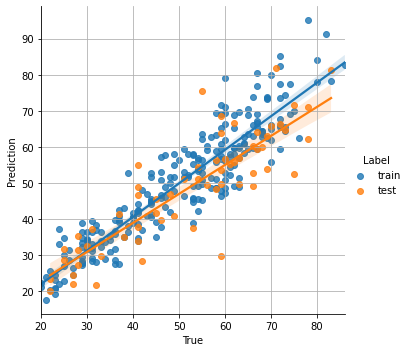

EPOCHS 306
TRAIN :: [LOSS] 6.683 | VALID :: [LOSS] 8.866


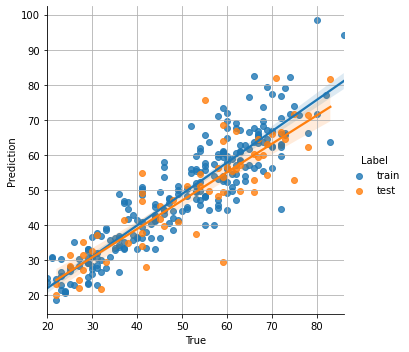

EPOCHS 307
TRAIN :: [LOSS] 6.225 | VALID :: [LOSS] 9.072


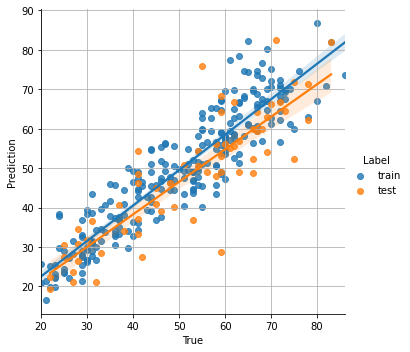

EPOCHS 308
TRAIN :: [LOSS] 5.916 | VALID :: [LOSS] 8.875


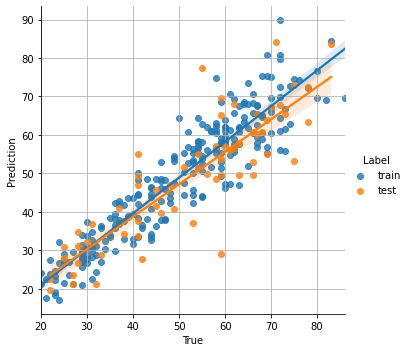

EPOCHS 309
TRAIN :: [LOSS] 6.357 | VALID :: [LOSS] 8.515


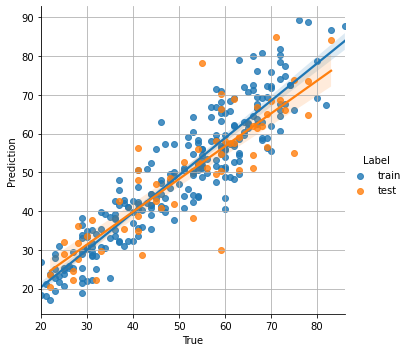

EPOCHS 310
TRAIN :: [LOSS] 6.388 | VALID :: [LOSS] 8.757


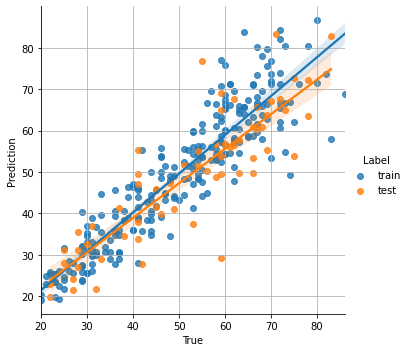

EPOCHS 311
TRAIN :: [LOSS] 6.209 | VALID :: [LOSS] 8.926


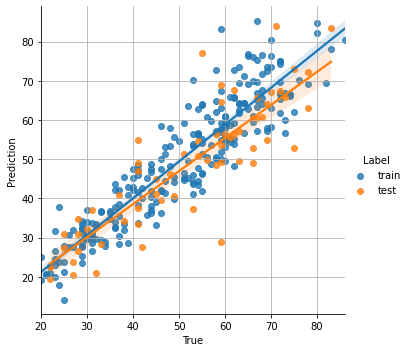

EPOCHS 312
TRAIN :: [LOSS] 5.820 | VALID :: [LOSS] 9.116


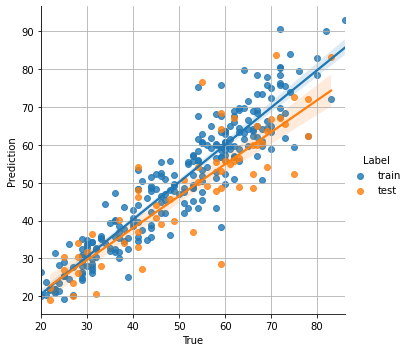

EPOCHS 313
TRAIN :: [LOSS] 5.772 | VALID :: [LOSS] 8.635


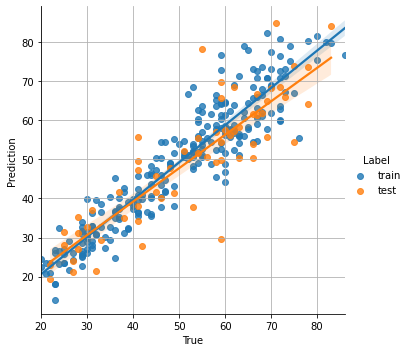

EPOCHS 314
TRAIN :: [LOSS] 6.184 | VALID :: [LOSS] 8.888


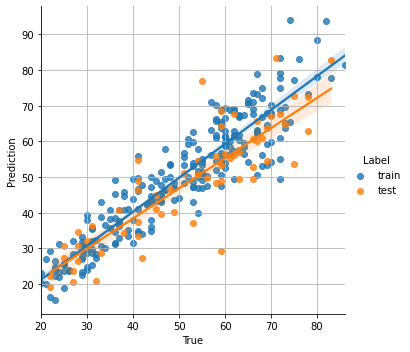

EPOCHS 315
TRAIN :: [LOSS] 6.393 | VALID :: [LOSS] 8.986


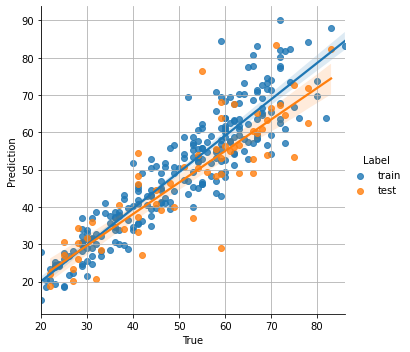

EPOCHS 316
TRAIN :: [LOSS] 5.792 | VALID :: [LOSS] 8.911


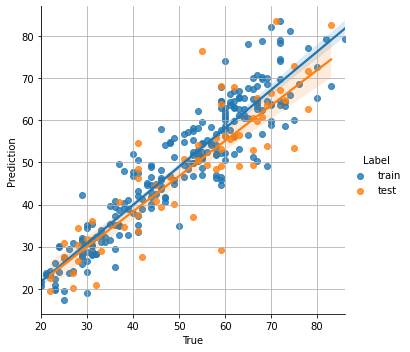

EPOCHS 317
TRAIN :: [LOSS] 6.382 | VALID :: [LOSS] 8.863


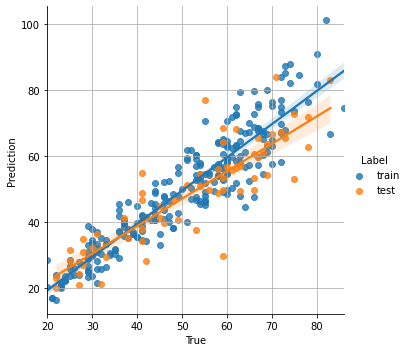

EPOCHS 318
TRAIN :: [LOSS] 6.087 | VALID :: [LOSS] 9.017


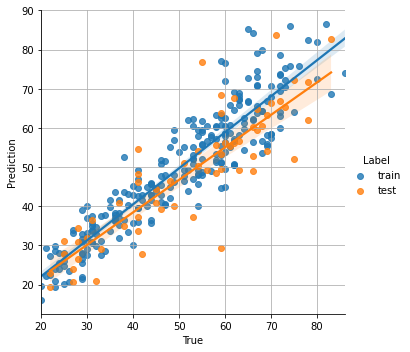

EPOCHS 319
TRAIN :: [LOSS] 6.421 | VALID :: [LOSS] 8.820


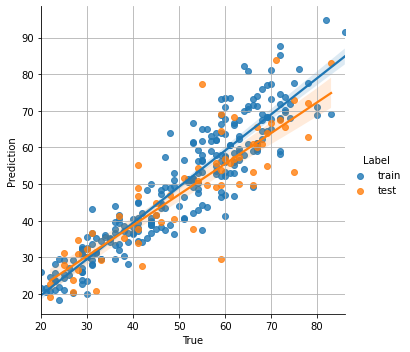

EPOCHS 320
TRAIN :: [LOSS] 6.057 | VALID :: [LOSS] 8.518


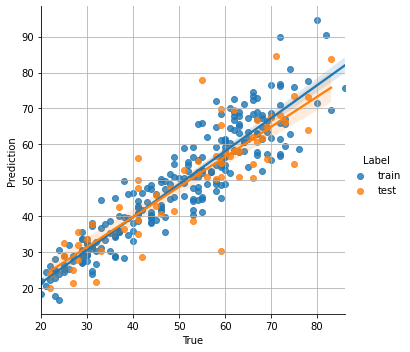

EPOCHS 321
TRAIN :: [LOSS] 6.143 | VALID :: [LOSS] 8.741


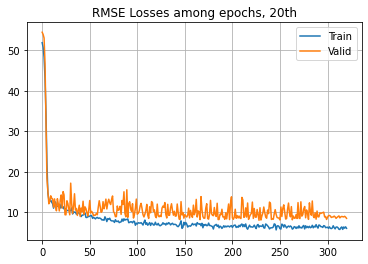

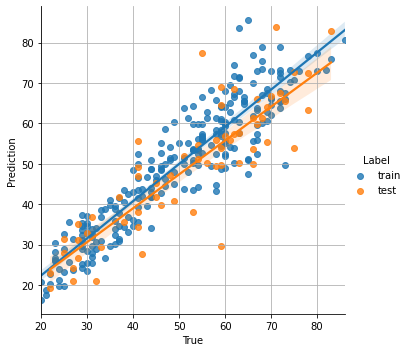

EPOCHS 322
TRAIN :: [LOSS] 6.218 | VALID :: [LOSS] 8.999


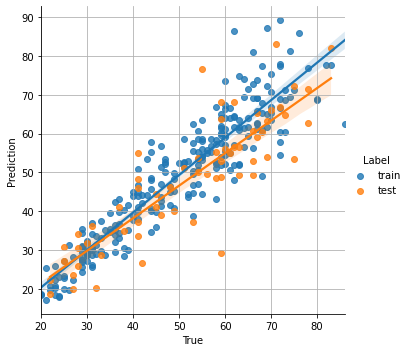

EPOCHS 323
TRAIN :: [LOSS] 6.432 | VALID :: [LOSS] 8.522


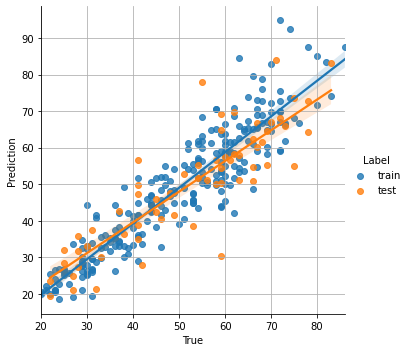

EPOCHS 324
TRAIN :: [LOSS] 6.019 | VALID :: [LOSS] 8.593


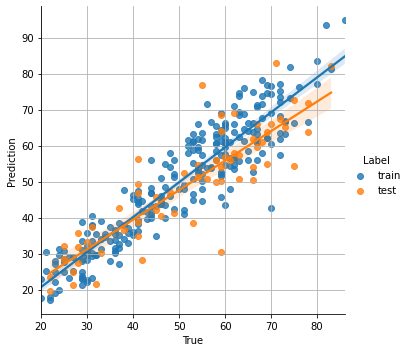

EPOCHS 325
TRAIN :: [LOSS] 5.924 | VALID :: [LOSS] 8.791


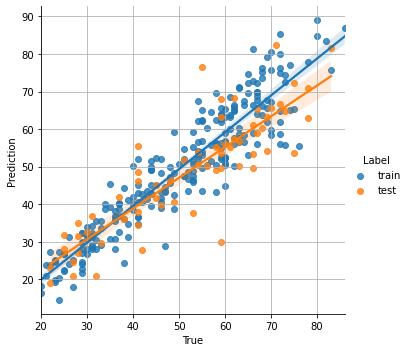

EPOCHS 326
TRAIN :: [LOSS] 5.976 | VALID :: [LOSS] 8.765


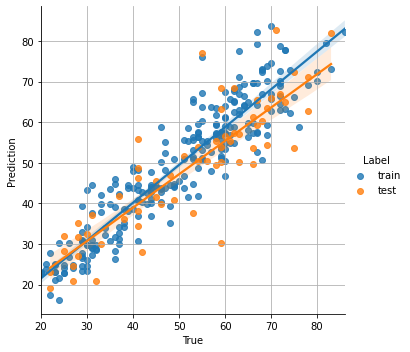

EPOCHS 327
TRAIN :: [LOSS] 6.396 | VALID :: [LOSS] 8.446


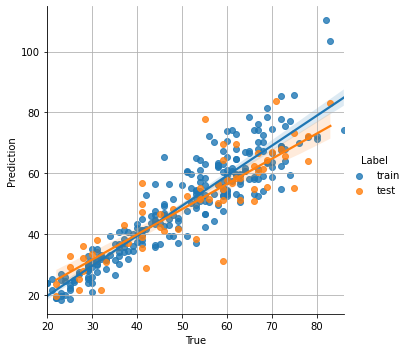

EPOCHS 328
TRAIN :: [LOSS] 5.630 | VALID :: [LOSS] 8.607


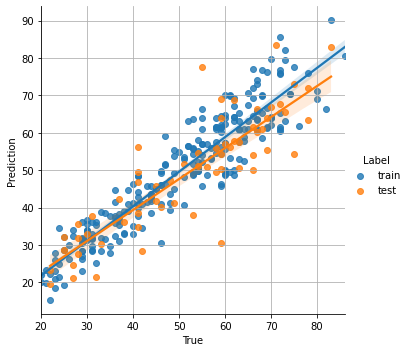

EPOCHS 329
TRAIN :: [LOSS] 6.614 | VALID :: [LOSS] 9.052


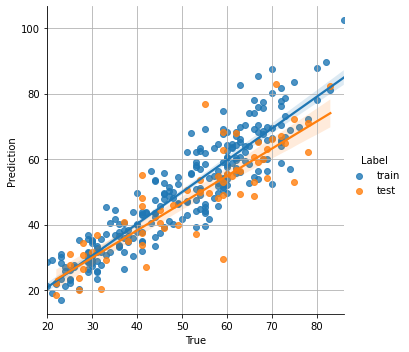

EPOCHS 330
TRAIN :: [LOSS] 6.491 | VALID :: [LOSS] 9.042


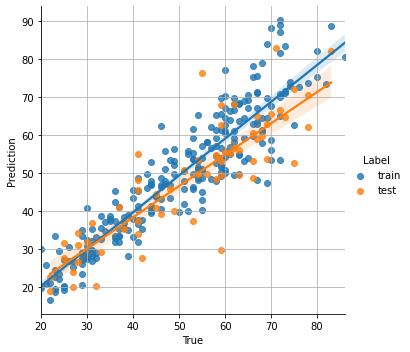

EPOCHS 331
TRAIN :: [LOSS] 6.440 | VALID :: [LOSS] 8.750


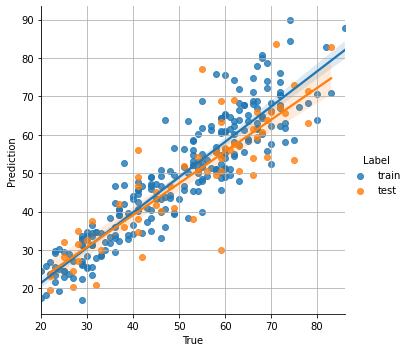

EPOCHS 332
TRAIN :: [LOSS] 6.099 | VALID :: [LOSS] 8.734


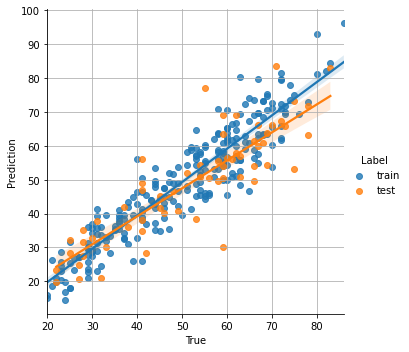

EPOCHS 333
TRAIN :: [LOSS] 6.678 | VALID :: [LOSS] 8.777


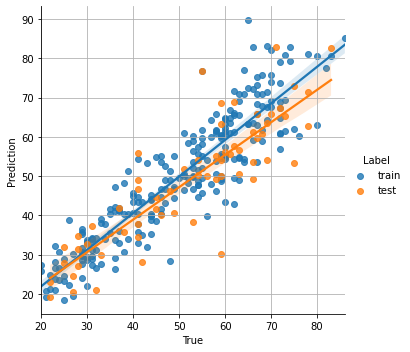

EPOCHS 334
TRAIN :: [LOSS] 6.054 | VALID :: [LOSS] 8.834


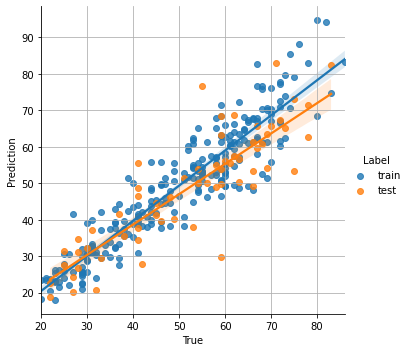

EPOCHS 335
TRAIN :: [LOSS] 5.765 | VALID :: [LOSS] 8.703


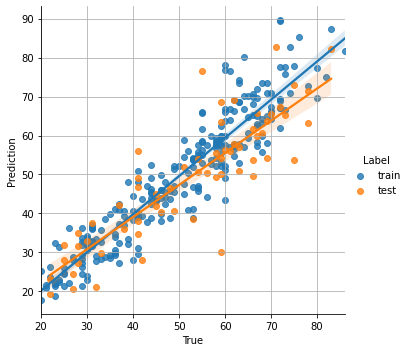

EPOCHS 336
TRAIN :: [LOSS] 5.966 | VALID :: [LOSS] 8.606


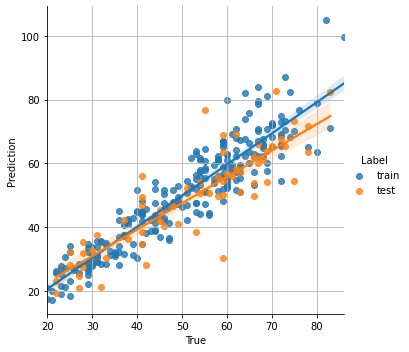

EPOCHS 337
TRAIN :: [LOSS] 6.629 | VALID :: [LOSS] 8.565


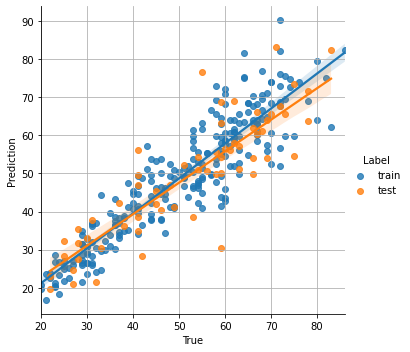

EPOCHS 338
TRAIN :: [LOSS] 5.997 | VALID :: [LOSS] 8.576


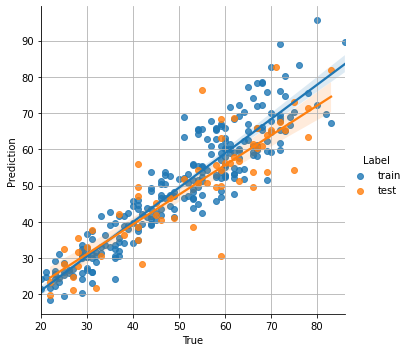

EPOCHS 339
TRAIN :: [LOSS] 6.028 | VALID :: [LOSS] 8.843


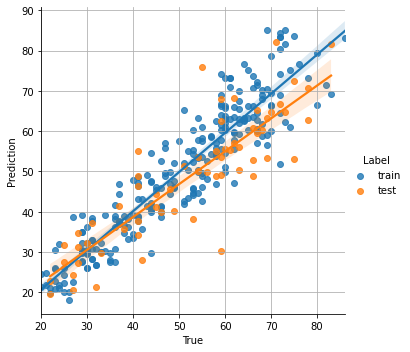

EPOCHS 340
TRAIN :: [LOSS] 5.780 | VALID :: [LOSS] 9.202


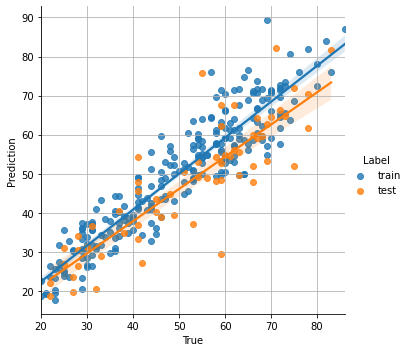

EPOCHS 341
TRAIN :: [LOSS] 6.301 | VALID :: [LOSS] 9.227


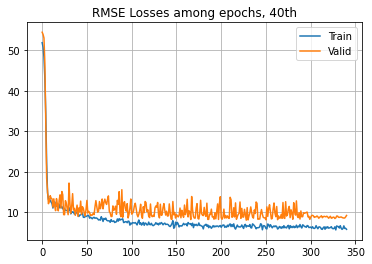

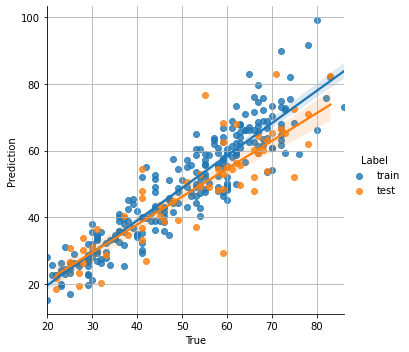

EPOCHS 342
TRAIN :: [LOSS] 6.340 | VALID :: [LOSS] 9.059


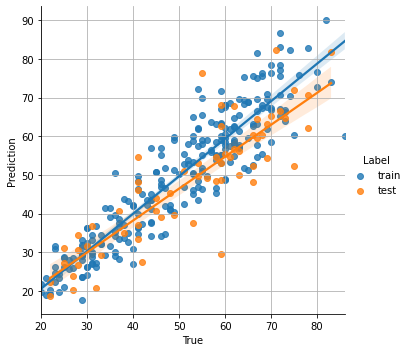

EPOCHS 343
TRAIN :: [LOSS] 5.862 | VALID :: [LOSS] 8.803


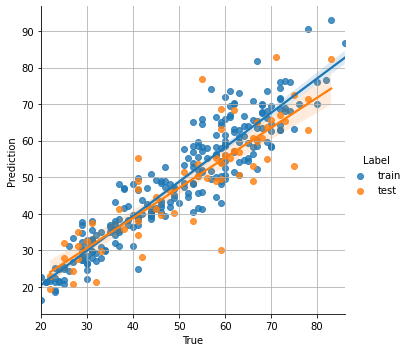

EPOCHS 344
TRAIN :: [LOSS] 6.160 | VALID :: [LOSS] 8.510


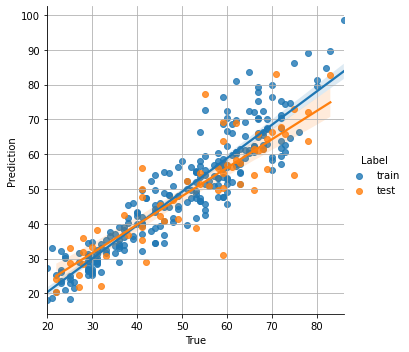

EPOCHS 345
TRAIN :: [LOSS] 5.789 | VALID :: [LOSS] 8.462


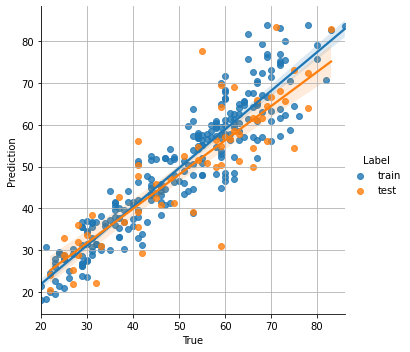

EPOCHS 346
TRAIN :: [LOSS] 5.702 | VALID :: [LOSS] 8.560


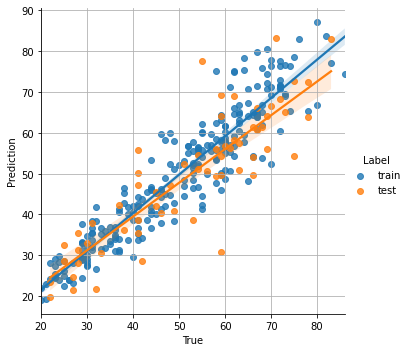

EPOCHS 347
TRAIN :: [LOSS] 5.887 | VALID :: [LOSS] 9.232


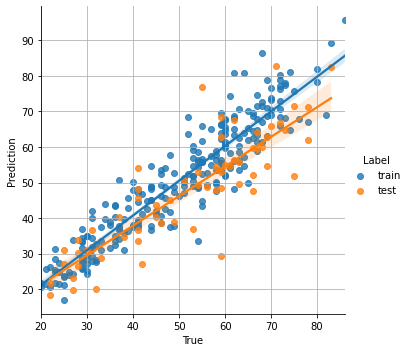

EPOCHS 348
TRAIN :: [LOSS] 5.655 | VALID :: [LOSS] 8.873


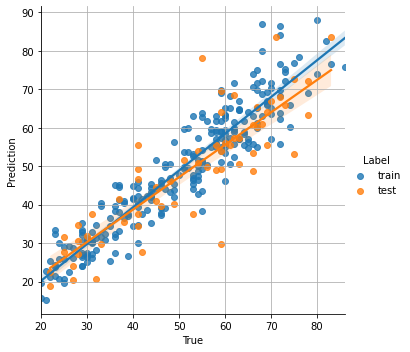

EPOCHS 349
TRAIN :: [LOSS] 5.960 | VALID :: [LOSS] 8.867


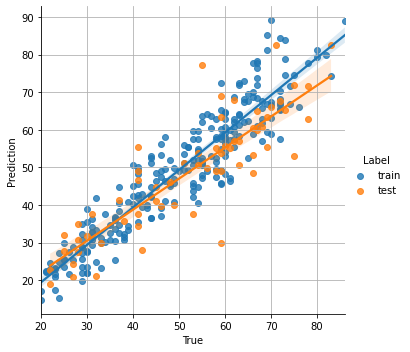

EPOCHS 350
TRAIN :: [LOSS] 5.939 | VALID :: [LOSS] 8.906


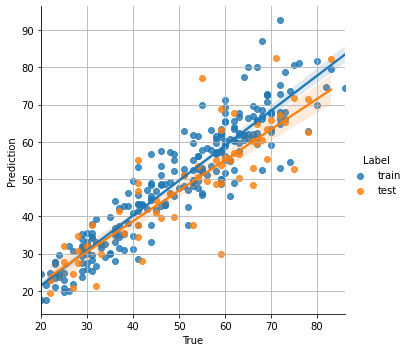

EPOCHS 351
TRAIN :: [LOSS] 6.345 | VALID :: [LOSS] 8.708


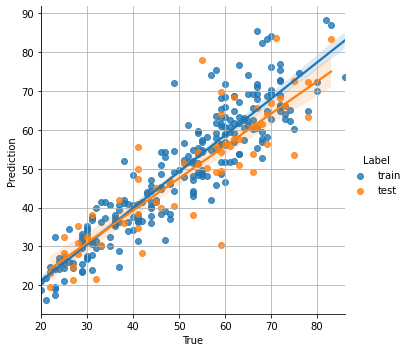

EPOCHS 352
TRAIN :: [LOSS] 6.005 | VALID :: [LOSS] 8.701


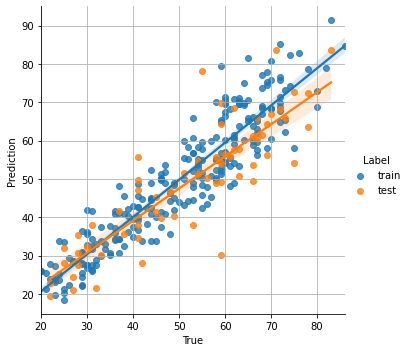

EPOCHS 353
TRAIN :: [LOSS] 6.280 | VALID :: [LOSS] 8.788


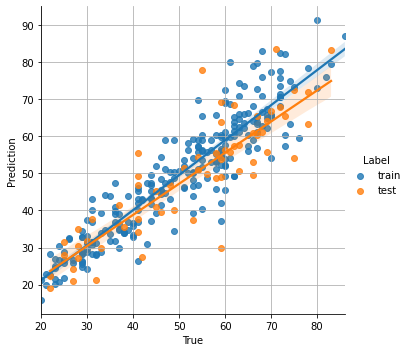

EPOCHS 354
TRAIN :: [LOSS] 6.372 | VALID :: [LOSS] 8.703


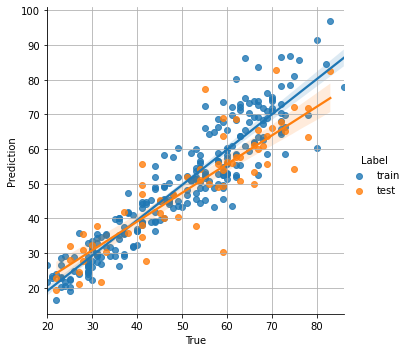

EPOCHS 355
TRAIN :: [LOSS] 6.199 | VALID :: [LOSS] 8.347


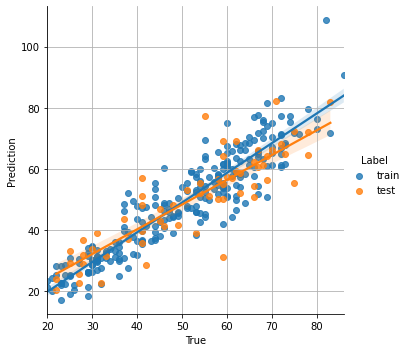

EPOCHS 356
TRAIN :: [LOSS] 5.615 | VALID :: [LOSS] 8.643


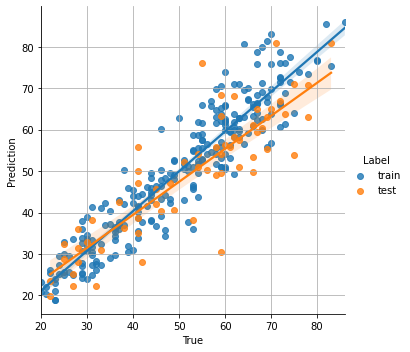

EPOCHS 357
TRAIN :: [LOSS] 5.631 | VALID :: [LOSS] 9.101


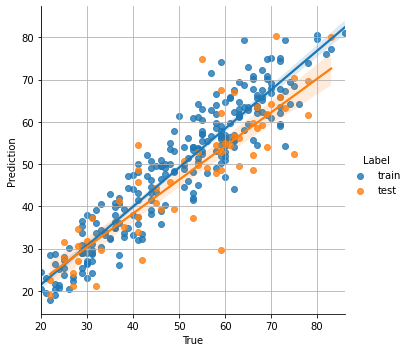

EPOCHS 358
TRAIN :: [LOSS] 6.425 | VALID :: [LOSS] 8.697


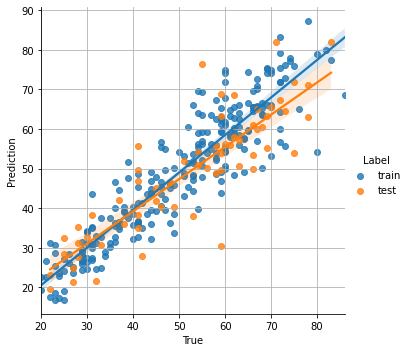

EPOCHS 359
TRAIN :: [LOSS] 6.226 | VALID :: [LOSS] 8.689


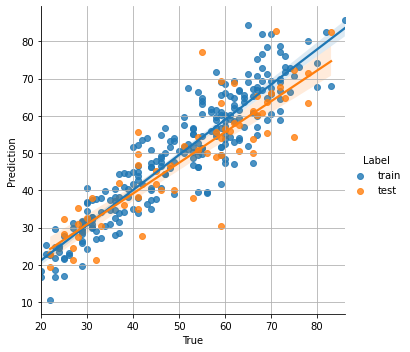

EPOCHS 360
TRAIN :: [LOSS] 6.881 | VALID :: [LOSS] 8.494


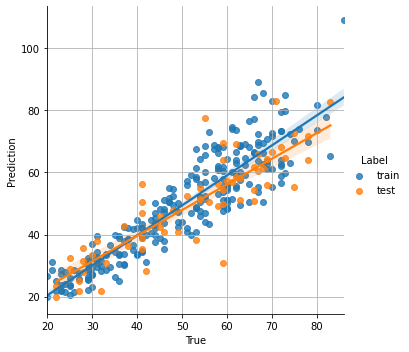

EPOCHS 361
TRAIN :: [LOSS] 5.718 | VALID :: [LOSS] 8.591


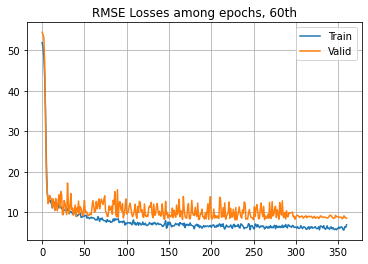

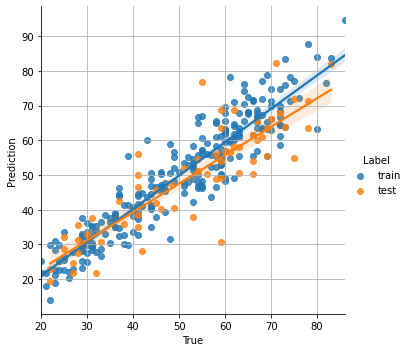

EPOCHS 362
TRAIN :: [LOSS] 6.207 | VALID :: [LOSS] 8.719


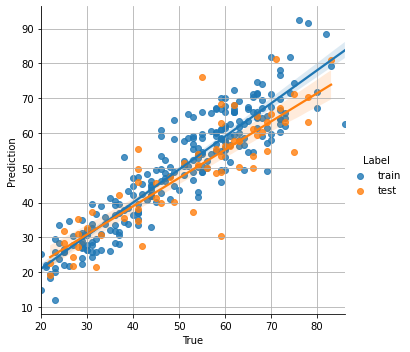

EPOCHS 363
TRAIN :: [LOSS] 6.009 | VALID :: [LOSS] 8.517


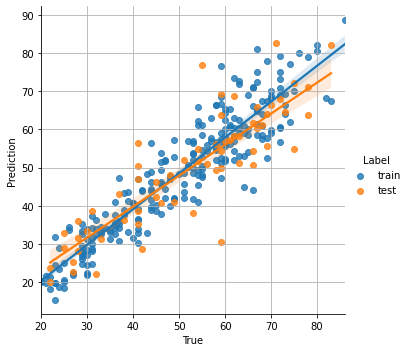

EPOCHS 364
TRAIN :: [LOSS] 5.896 | VALID :: [LOSS] 8.458


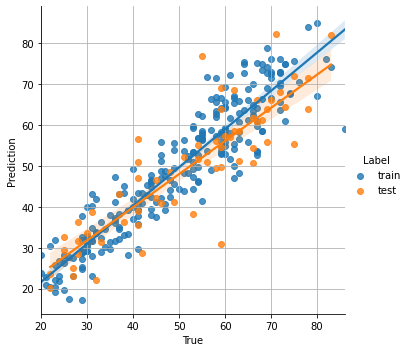

EPOCHS 365
TRAIN :: [LOSS] 5.720 | VALID :: [LOSS] 8.890


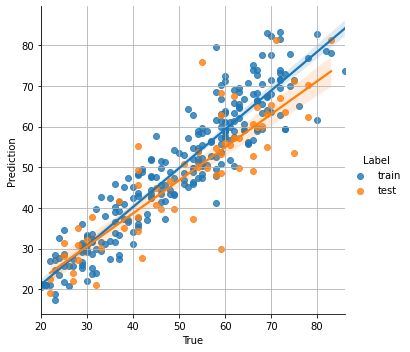

EPOCHS 366
TRAIN :: [LOSS] 5.668 | VALID :: [LOSS] 9.134


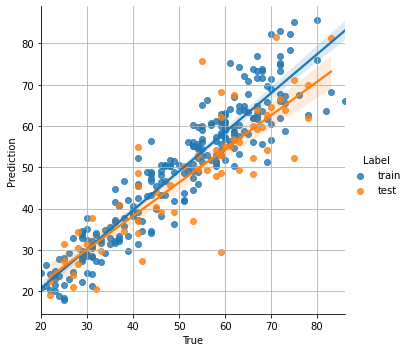

EPOCHS 367
TRAIN :: [LOSS] 6.254 | VALID :: [LOSS] 9.064


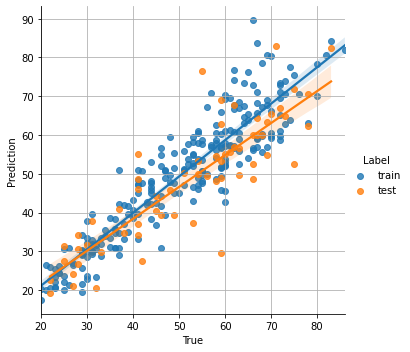

EPOCHS 368
TRAIN :: [LOSS] 5.388 | VALID :: [LOSS] 8.808


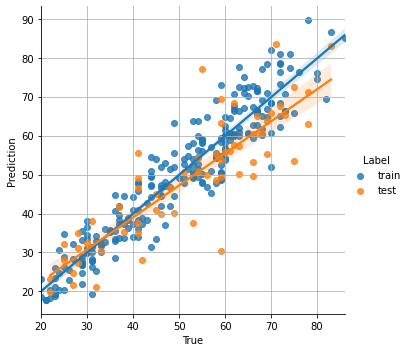

EPOCHS 369
TRAIN :: [LOSS] 5.951 | VALID :: [LOSS] 8.703


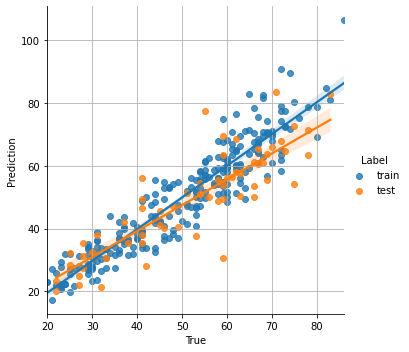

In [ ]:
# trn_losses, tst_losses = [], []
best_loss = 100
for e in range(300):

    # TRAIN
    trn_bth_loss = 0
    trn_trues, trn_preds = [], []
    model.train()
    for i, (x, y) in enumerate(train_loader):

        if resize:
            x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

        else:
            x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x).to(device)

        trn_trues.append(y.to('cpu'))
        trn_preds.append(y_pred.to('cpu'))

        loss = torch.sqrt(loss_fn(y_pred.squeeze(1), y))
        del x, y, y_pred

        loss.backward()
        optimizer.step()
        if scheduler: scheduler.step()

        trn_bth_loss += loss.item()

    torch.cuda.empty_cache()
    
    ### loss
    trn_losses.append(trn_bth_loss / len(train_loader))

    ### collect trues/predictions
    trn_trues = list(chain(*trn_trues))
    trn_preds = list(chain(*trn_preds))

        
    # TEST
    tst_bth_loss = 0
    model.eval()
    tst_trues, tst_preds = [], []
    with torch.no_grad(): # to not give loads on GPU... :(
        for i, (x, y) in enumerate(test_loader):
            if resize:
                x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

            else:
                x, y = x.to(device), y.to(device)

            y_pred = model.forward(x).to(device)

            tst_trues.append(y.to('cpu'))
            tst_preds.append(y_pred.to('cpu'))

            loss = torch.sqrt(loss_fn(y_pred.squeeze(1), y))
            del x, y, y_pred

            tst_bth_loss += loss.item()

    torch.cuda.empty_cache()
    ### loss
    tst_losses.append(tst_bth_loss / len(test_loader))

    ### collect trues/predictions
    tst_trues = list(chain(*tst_trues))
    tst_preds = list(chain(*tst_preds))
    
    reg_df = pd.DataFrame({
        'True': list(map(float, trn_trues + tst_trues)),
        'Prediction': list(map(float, trn_preds + tst_preds)),
        'Label': ['train'] * 250 + ['test'] * 62
    })

    print(f'EPOCHS {e+300}')
    print(f'RMSE :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {tst_losses[-1]:.3f}')
    print(f'BEST )
    
    sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
    plt.grid()
    plt.show()
    
    if best_loss - .02 > tst_losses[-1]:
        
        date = f'{datetime.now().strftime("%Y-%m-%d_%H%M")}'
        fname = f"./models/{date}_{tst_losses[-1]:.3f}_model.pth"
        torch.save(model, fname)
        best_loss = max(tst_losses[-1], best_loss)
        
    summary.add_scalars('loss/RMSE_loss',
                         {'Train Loss': trn_losses[-1],
                          'Valid Loss': tst_losses[-1]}, e+300)
    
    if (e + 300) % 20 == 0:
        plt.plot(trn_losses, label='Train')
        plt.plot(tst_losses, label='Valid')
        plt.title(f"RMSE Losses among epochs, {e}th")
        #plt.ylim(0, 500)
        plt.grid()
        plt.legend()

In [16]:
min(trn_losses)

5.659356459975243

In [15]:
min(tst_losses)

8.03717052936554

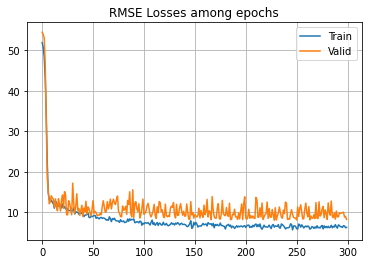

In [22]:
plt.plot(trn_losses, label='Train')
plt.plot(tst_losses, label='Valid')
plt.title("RMSE Losses among epochs")
plt.hlines(min(tst_losses), color='red')
#plt.ylim(0, 500)
plt.grid()
plt.legend()

In [12]:
# %load ../2d_slice/src/slice_viewer.py

In [13]:
# SliceViewer(np.array(train_dset[0][0][0])).triple_view()